In [1]:
import colorthief as ct
import requests
from io import BytesIO
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
from skimage.color import rgb2hsv, hsv2rgb

In [2]:
def in_date(soup):
    try:
        return int(soup.find('span').next[1:-1])>2015
    except:
        return False

In [10]:
# Get a big list of the games to identify
games = []
for i in range(1,40):
    url = 'https://boardgamegeek.com/browse/boardgame/page/'+str(i)
    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    games.extend([x.find_all('a')[1]['href'] for x in soup.find_all(id="row_") if in_date(x) ])

In [11]:
import json
import statistics
import sys
params = []
total = len(games)
sys.stdout.write('0 of '+str(total))
for game in games:
    try:
        url = 'https://boardgamegeek.com'+game
        soup = BeautifulSoup(requests.get(url).text, 'html.parser')
        image_url = json.loads(soup.find_all('script')[-1].next)['image']
        colour_thief = ct.ColorThief(BytesIO(requests.get(image_url).content))
        greyscale = statistics.mean(colour_thief.get_color(quality=1))
        age_string = soup.find_all('script')[0].next
        age_pos = age_string.find(',"playerage":"')
        age = int(age_string[age_pos+14:age_pos+20].split('+')[0])
        params.append((greyscale, age))
        sys.stdout.write('\r')
        sys.stdout.write(str(len(params))+' of '+str(total))
        sys.stdout.flush()
    except:
        pass

1131 of 1202

In [32]:
import numpy as np
from numpy.polynomial.polynomial import polyfit
ctd = ct.ColorThief('./DarkBox.png')
ctl = ct.ColorThief('./LightBox.png')
gsd = statistics.mean(ctd.get_color(quality=1))
gsl = statistics.mean(ctl.get_color(quality=1))

greyscales, ages = zip(*params)
x = np.array(ages)
y = np.array(greyscales)

pfb = polyfit(x[0:100], y[0:100], 1, full=True)
print(pfb[0])

pf = polyfit(x[100:1000], y[100:1000], 1, full=True)
print(pfb[0])

[161.76164116  -4.73119505]
[161.76164116  -4.73119505]


Text(0.5,0,'BGG Age Catagory')

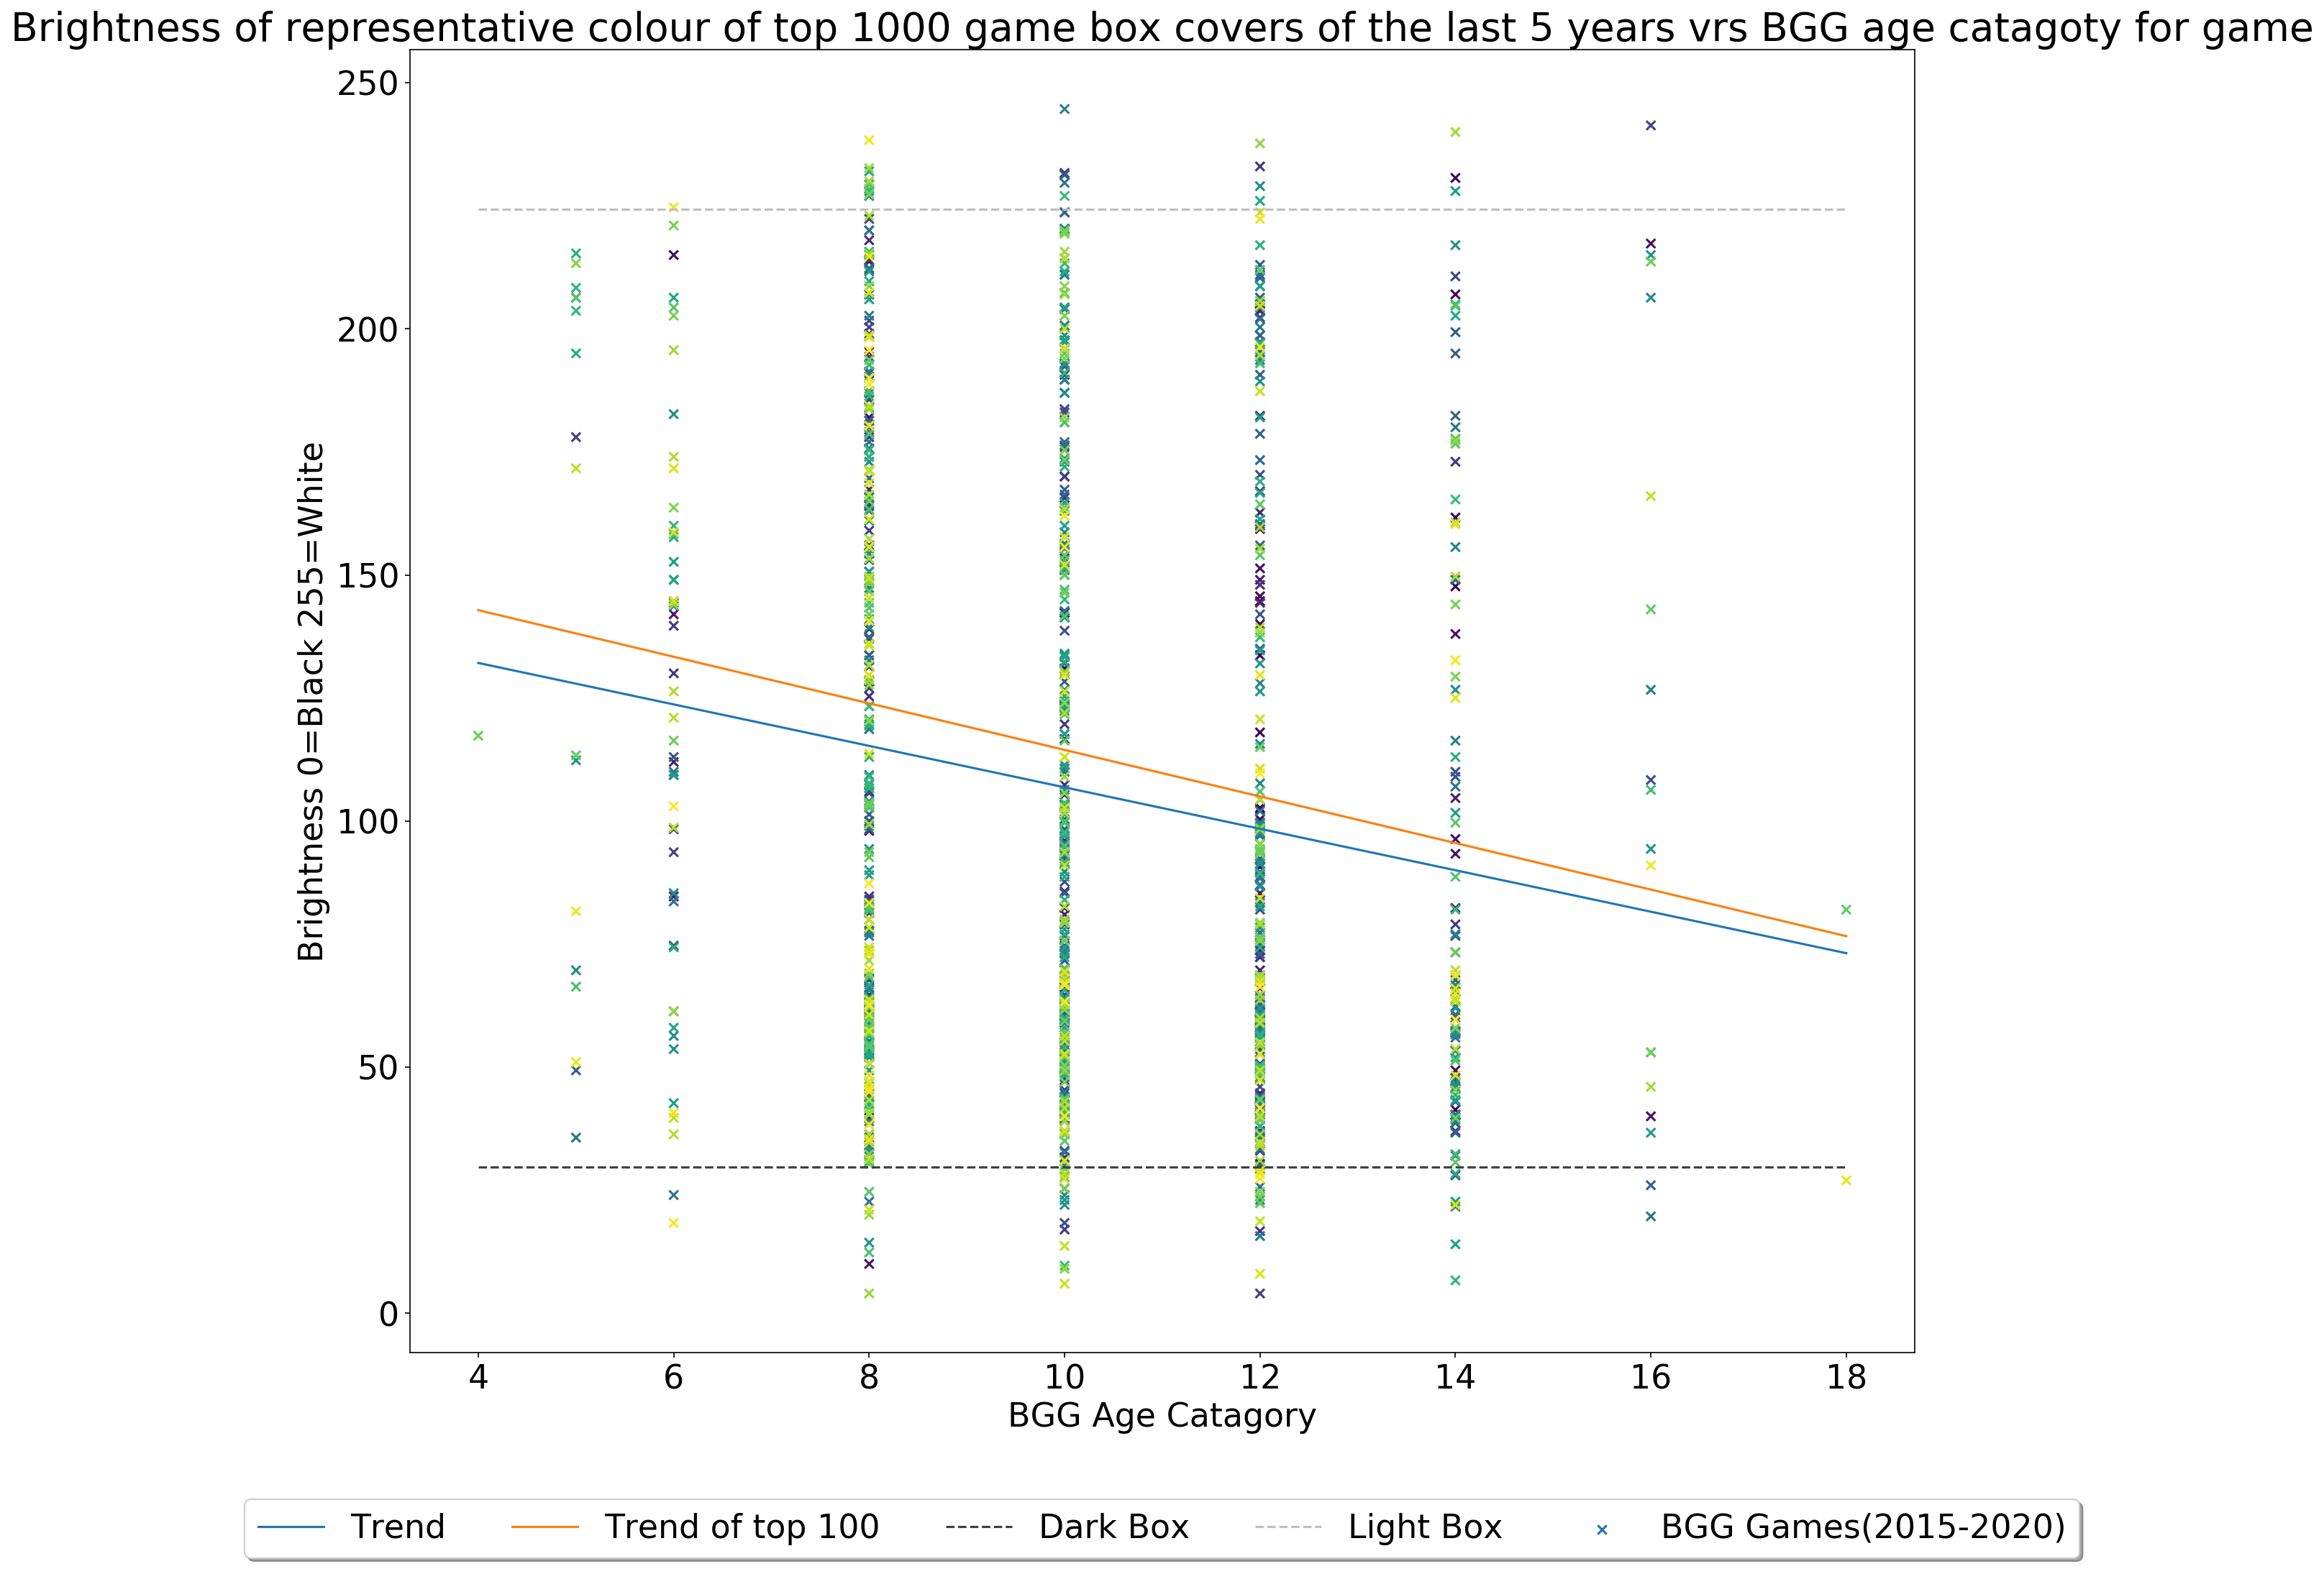

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16), dpi= 150, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.scatter(x, y, c=np.arange(x.shape[0]), marker='x', label='BGG Games(2015-2020)')

plt.plot(np.unique(x), pf[0][0] + pf[0][1] * np.unique(x), '-', label='Trend')
plt.plot(np.unique(x), pfb[0][0] + pfb[0][1] * np.unique(x), '-', label='Trend of top 100')
#plt.plot(np.unique(x), (pf[0][0]+pf[1][2][0]*5) + (pf[0][1]-pf[1][2][1]*5) * np.unique(x), '-')
#plt.plot(np.unique(x), (pf[0][0]-pf[1][2][0]*5) + (pf[0][1]+pf[1][2][1]*5) * np.unique(x), '-')

plt.plot(np.unique(x), gsd + 0 * np.unique(x), '--', color='0.25', label='Dark Box')
plt.plot(np.unique(x), gsl + 0 * np.unique(x), '--', color='0.75', label='Light Box')

plt.title("Brightness of representative colour of top 1000 game box covers of the last 5 years vrs BGG age catagoty for game")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel('Brightness 0=Black 255=White')
plt.xlabel('BGG Age Catagory')

In [ ]:
# Done at this point, should tidy up

In [ ]:
import urllib.parse
import json
import statistics
def get_boardgame_stats(game_name):
    url = 'https://boardgamegeek.com/geeksearch.php?action=search&objecttype=boardgame&q='+urllib.parse.quote(game_name)
    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    best_url = soup.find(id="results_objectname1").find(href=True)['href']
    url = 'https://boardgamegeek.com'+best_url
    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    image_url = json.loads(soup.find_all('script')[-1].next)['image']
    colour_thief = ct.ColorThief(BytesIO(requests.get(image_url).content))
    greyscale = statistics.mean(colour_thief.get_color(quality=1))
    age_string = soup.find_all('script')[0].next
    age_pos = age_string.find(',"playerage":"')
    age = int(age_string[age_pos+14:age_pos+20].split('+')[0])
    return (greyscale, age)

In [ ]:
get_boardgame_stats('Arkham Horror')

In [ ]:
<div class="gameplay-item-primary"> 					Age: 					<!-- ngIf: ::geekitemctrl.geekitem.data.item.minage == 0 --> 					<!-- ngIf: ::geekitemctrl.geekitem.data.item.minage > 0 --><span ng-if="::geekitemctrl.geekitem.data.item.minage > 0" class="ng-binding ng-scope"> 						12+ 					</span><!-- end ngIf: ::geekitemctrl.geekitem.data.item.minage > 0 --> 				</div>

In [ ]:
 {'valign':re.compile('top')}

In [ ]:
# Grab the data from the boardgame geek website
url = 'https://boardgamegeek.com/browse/boardgame'
response = requests.get(url)    

In [ ]:
soup = BeautifulSoup(response.text, 'html.parser')

In [ ]:
# Get all the thumbnail images from the games
thumb = [x.findAll('img')[0]['src'] for x in soup.findAll('td')  if 'collection_thumbnail' in x['class']]

In [ ]:
# Get the colour information from them
colour_thief = [ct.ColorThief(BytesIO(requests.get(x).content)) for x in thumb]

In [ ]:
# Get all the dominant colours
dominant = [x.get_color(quality=1) for x in colour_thief]

In [ ]:
# Plot the dominant colours on the funky colour thingy which lets you display RGB in 2D
import numpy as np
RGB = np.array(dominant)
from colour.plotting import plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931, colour_style
colour_style()
plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(
    [RGB], 'ITU-R BT.709')

In [ ]:
# get the 6 representative palette colours
palette = [x.get_palette(color_count=6, quality=1) for x in colour_thief]

In [ ]:
# And plot them in the same way
RGBP = np.array(palette)
BGG_palette = rgb2hsv(RGBP)
BGG_Bright = RGBP.mean(axis=2)
plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(
    RGBP, 'ITU-R BT.709')

In [ ]:
# Grab the data from the Amazon.co.uk 
url = 'https://www.amazon.co.uk/Best-Sellers-Toys-Games-Board/zgbs/kids/364146031'
response = requests.get(url)    
soup = BeautifulSoup(response.text, 'html.parser')

In [ ]:
# Get all the thumbnail images from the games
thumb = [x.findAll('img')[0]['src'] for x in soup.findAll('li')  if x.has_attr('class') and 'zg-item-immersion' in x['class']]

In [ ]:
# Get the colour information from them
colour_thief = [ct.ColorThief(BytesIO(requests.get(x).content)) for x in thumb]

In [ ]:
# Get all the dominant colours
dominant = [x.get_color(quality=1) for x in colour_thief]

In [ ]:
# Plot the dominant colours on the funky colour thingy which lets you display RGB in 2D
import numpy as np
RGB = np.array(dominant)
from colour.plotting import plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931, colour_style
colour_style()
plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(
    [RGB], 'ITU-R BT.709')

In [ ]:
# get the 6 representative palette colours
palette = [x.get_palette(color_count=6, quality=1) for x in colour_thief]

In [ ]:
# And plot them in the same way
RGBP = np.array(palette)
AUK_palette = rgb2hsv(RGBP)
plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(
    RGBP, 'ITU-R BT.709')

In [ ]:
# Grab the data from the Amazon.co.uk 
url = 'https://www.amazon.com/Best-Sellers-Toys-Games-Board/zgbs/toys-and-games/166225011'
response = requests.get(url)    
soup = BeautifulSoup(response.text, 'html.parser')

In [ ]:
# Get all the thumbnail images from the games
thumb = [x.findAll('img')[0]['src'] for x in soup.findAll('li')  if x.has_attr('class') and 'zg-item-immersion' in x['class']]

In [ ]:
# Get the colour information from them
colour_thief = [ct.ColorThief(BytesIO(requests.get(x).content)) for x in thumb]

In [ ]:
# Get all the dominant colours
dominant = [x.get_color(quality=1) for x in colour_thief]

In [ ]:
# Plot the dominant colours on the funky colour thingy which lets you display RGB in 2D
import numpy as np
RGB = np.array(dominant)
from colour.plotting import plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931, colour_style
colour_style()
plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(
    [RGB], 'ITU-R BT.709')

In [ ]:
# get the 6 representative palette colours
palette = [x.get_palette(color_count=6, quality=1) for x in colour_thief]

In [ ]:
# And plot them in the same way
RGBP = np.array(palette)
AUS_palette = rgb2hsv(RGBP)
plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(
    RGBP, 'ITU-R BT.709')

In [ ]:
histR,bins = np.histogram(RGB[:,0],bins = [0,25,50,75,100,125,150,175,200,225,250])
histG,bins = np.histogram(RGB[:,1],bins = [0,25,50,75,100,125,150,175,200,225,250])
histB,bins = np.histogram(RGB[:,2],bins = [0,25,50,75,100,125,150,175,200,225,250])

In [ ]:
from matplotlib import pyplot as plt 

plt.hist(RGB, bins = [0,25,50,75,100,125,150,175,200,225,250], histtype='barstacked', color=('r', 'g', 'b')) 
plt.title("histogram") 
plt.show()

In [ ]:
bins

In [ ]:
ctd = ct.ColorThief('./DarkBox.png')
ctl = ct.ColorThief('./LightBox.png')

In [ ]:
p1 = ctd.get_palette(color_count=6, quality=1)
p2 = ctl.get_palette(color_count=6, quality=1)
RGBP = np.array([p1,p2])
BOX_palette = rgb2hsv(RGBP)

In [ ]:
BOX_palette.shape

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(BGG_palette[:,:,0], BGG_palette[:,:,1], c='b', marker="x", label='Board Game Geek')
ax1.scatter(AUK_palette[:,:,0], AUK_palette[:,:,1], c='r', marker="x", label='Amazon UK')
ax1.scatter(AUS_palette[:,:,0], AUS_palette[:,:,1], c='g', marker="x", label='Amazon US')
ax1.scatter(BOX_palette[0,:,0], BOX_palette[0,:,1], s=50, c='k', marker="o", label='Dark Box')
ax1.scatter(BOX_palette[1,:,0], BOX_palette[1,:,1], s=50, c='k', marker="s", label='Light Box')
plt.legend(loc='upper right');
plt.show()

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(BGG_palette[:,:,0], BGG_palette[:,:,1], c='b', marker="x", label='Board Game Geek')
plt.legend(loc='upper right');
plt.show()

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(BGG_palette[:,:,0], BGG_Bright[:,:], c='b', marker="x", label='Board Game Geek')
plt.legend(loc='upper right');
plt.show()

In [ ]:
hue_gradient = np.linspace(0, 1, 100)
hsv = np.ones(shape=(5, len(hue_gradient), 3), dtype=float)
hsv[:, :, 0] = hue_gradient
all_hues = hsv2rgb(hsv)

In [ ]:
fig_synth = plt.figure("synth")
plt.imshow(all_hues, interpolation='nearest')
plt.xlabel("Hue")
plt.show()